# Pytorch starter - FasterRCNN Train
In this notebook I enabled the GPU and the Internet access (needed for the pre-trained weights). We can not use Internet during inference, so I'll create another notebook for commiting. Stay tuned!

You can find the [inference notebook here](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference)

- FasterRCNN from torchvision
- Use Resnet50 backbone
- Albumentation enabled (simple flip for now)

https://pytorch.org/vision/main/models.html


In [1]:
# !pip install albumentations

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

from sklearn.metrics import average_precision_score
from tqdm import tqdm

import rasterio

DIR_INPUT = '../datasets/01m-All-1'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VALID = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'
NUM_CHANNELS = 3 # Number of input image channels RGB + Extras
NUM_CLASSES = 6 # Number of classes in the dataset

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:

class YOLOTifDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        """
        Args:
            root_dir (str): Directory containing `images/`, `labels/`, and `edge_images/` subdirectories.
            transforms (callable, optional): A function/transform to apply to the images.
        """
        self.image_dir = os.path.join(root_dir, "old_images")
        # self.priviliged_dir = os.path.join(root_dir, "edge_images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.transforms = transforms
        self.image_filenames = [f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        # self.priviliged_filenames = [f for f in os.listdir(self.priviliged_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image
        img_filename = self.image_filenames[idx]
        # priviliged_filename = self.priviliged_filenames[idx]

        img_path = os.path.join(self.image_dir, img_filename)
        # priviliged_path = os.path.join(self.priviliged_dir, priviliged_filename)

        # Load images using OpenCV and convert from BGR to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0  # Normalize image to [0, 1]

        # priviliged = cv2.imread(priviliged_path, cv2.IMREAD_GRAYSCALE)
        # priviliged = priviliged.astype(np.float32) / 255.0  # Normalize privileged image to [0, 1]

        # Convert to PyTorch tensors
        img_tensor = torch.tensor(img).permute(2, 0, 1)  # Convert to (C, H, W) for RGB image
        # priviliged_tensor = torch.tensor(priviliged).unsqueeze(0)  # Add channel dimension (1, H, W) for privileged image

        # Concatenate the privileged image with the original image
        # img = torch.cat((img_tensor, priviliged_tensor), dim=0)  # Shape will be (C+1, H, W)
        img = img_tensor

        # Load YOLO annotations
        label_filename = img_filename.rsplit('.', 1)[0] + '.txt'  # Replace image extension with .txt
        label_path = os.path.join(self.label_dir, label_filename)

        boxes = []
        labels = []
        target_ids = []  # Add target_id for each instance

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    values = list(map(float, line.strip().split()))
                    class_id = int(values[0])
                    annotations = values[1:]

                    # If the annotations are polygonal, we need to convert them to bounding boxes
                    if len(annotations) > 4:
                        # Convert polygons to a box enclosing the polygon
                        box_coords = np.array(annotations).reshape(-1, 2)
                        x_min = np.min(box_coords[:, 0])
                        y_min = np.min(box_coords[:, 1])
                        x_max = np.max(box_coords[:, 0])
                        y_max = np.max(box_coords[:, 1])

                        boxes.append([x_min, y_min, x_max, y_max])
                    else:
                        x, y, w, h = annotations
                        x_min = x - w / 2
                        y_min = y - h / 2
                        x_max = x + w / 2
                        y_max = y + h / 2

                        boxes.append([x_min, y_min, x_max, y_max])

                    labels.append(class_id)
                    target_ids.append(len(boxes) - 1)

        # COCO-style dictionary format (matching WheatDataset)
        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),  # Bounding boxes (x_min, y_min, x_max, y_max)
            'labels': torch.tensor(labels, dtype=torch.int64),  # Class IDs
            'image_id': torch.tensor([idx]),  # Image ID (index of the image)
            'area': torch.tensor([(box[2] - box[0]) * (box[3] - box[1]) for box in boxes], dtype=torch.float32),  # Area of the box
            'iscrowd': torch.zeros(len(boxes), dtype=torch.int64)  # Assume all instances are not crowd
        }

        # Apply data augmentation if available
        if self.transforms:
            sample = {'image': img, 'bboxes': target['boxes'], 'labels': target['labels']}
            sample = self.transforms(sample)
            img = sample['image']
            target['boxes'] = sample['bboxes']
            target['labels'] = sample['labels']

        return img, target

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define train and validation transformations
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),  # Flip images horizontally with a probability of 0.5
        A.VerticalFlip(p=0.5),    # Optionally, flip images vertically (remove if not needed)
        ToTensorV2(p=1.0)         # Ensure the image is converted to a tensor
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)         # Ensure the image is converted to a tensor
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Example usage with images that have more than 3 channels
def transform_image(image, transform):
    # Example: If your image has more than 3 channels, ensure to specify the number of channels
    augmented = transform(image=image)
    return augmented['image']  # Return the augmented image (tensor)


# Create the model

In [5]:
# load a model; pre-trained on COCO
# Load the FasterRCNN model with pretrained weights
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

# Modify the first convolutional layer for 4-channel input
model.backbone.body.conv1 = torch.nn.Conv2d(NUM_CHANNELS, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Dynamically set image mean and std for 4-channel input
model.transform.image_mean = [0.485] * NUM_CHANNELS
model.transform.image_std = [0.229] * NUM_CHANNELS

# Get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Freeze all parameters except for the first convolutional layer and the last layer for predictions
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the first convolutional layer
for param in model.backbone.body.conv1.parameters():
    param.requires_grad = True

# Unfreeze the classifier (last layer) for predictions
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

# Move the model to the correct device (e.g., CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Verify the model structure
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = YOLOTifDataset(DIR_TRAIN)#, get_train_transform())
valid_dataset = YOLOTifDataset(DIR_VALID)#, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
batch_size = 4
num_workers = 0

torch.multiprocessing.set_start_method('spawn')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
)

In [8]:
images, targets= train_data_loader.dataset[0]
print(images.shape, targets)

torch.Size([3, 3024, 4032]) {'boxes': tensor([[0.3616, 0.3922, 0.4901, 0.6647],
        [0.8466, 0.8598, 0.9706, 1.0000]]), 'labels': tensor([2, 0]), 'image_id': tensor([0]), 'area': tensor([0.0350, 0.0174]), 'iscrowd': tensor([0, 0])}


# Sample

In [9]:
images, targets, = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

(3024, 4032, 3)


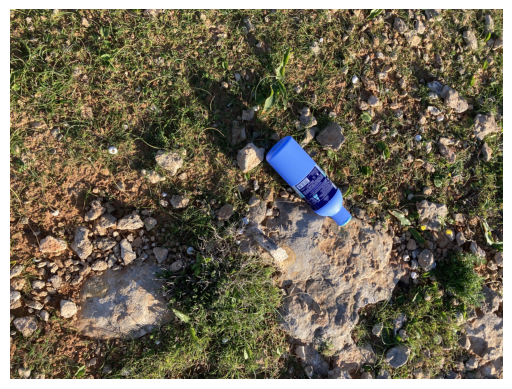

In [10]:
# Extract and reshape the image for the 2nd sample
sample_image = images[0].cpu().numpy()

# Keep only the first 3 RGB channels
red_channel = sample_image[0]
green_channel = sample_image[1]
blue_channel = sample_image[2]
# Edge channel will be ignored for now
# edge_channel = sample_image[3]

red_channel = (red_channel * 255).astype(np.uint8)
green_channel = (green_channel * 255).astype(np.uint8)
blue_channel = (blue_channel * 255).astype(np.uint8)

# Stack the channels to form the RGB image
sample_image_rgb = np.stack([red_channel, green_channel, blue_channel], axis=-1)

print(sample_image_rgb.shape)  # This should give you (height, width, 3) for RGB channels

# Plot the image using Matplotlib
plt.imshow(sample_image_rgb)
plt.axis('off')
plt.show()


In [11]:
targets

[{'boxes': tensor([[0.5117, 0.3318, 0.6986, 0.5985]], device='cuda:0'),
  'labels': tensor([5], device='cuda:0'),
  'image_id': tensor([78], device='cuda:0'),
  'area': tensor([0.0498], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[0.0000, 0.6885, 0.0570, 0.8179],
          [0.4932, 0.2490, 0.7064, 0.3613],
          [0.0000, 0.1086, 0.2148, 0.2246]], device='cuda:0'),
  'labels': tensor([1, 1, 0], device='cuda:0'),
  'image_id': tensor([255], device='cuda:0'),
  'area': tensor([0.0074, 0.0239, 0.0249], device='cuda:0'),
  'iscrowd': tensor([0, 0, 0], device='cuda:0')},
 {'boxes': tensor([[0.5506, 0.5809, 0.7680, 0.8521]], device='cuda:0'),
  'labels': tensor([5], device='cuda:0'),
  'image_id': tensor([159], device='cuda:0'),
  'area': tensor([0.0590], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[0.5217, 0.2899, 0.6523, 0.7176]], device='cuda:0'),
  'labels': tensor([0], device='cuda:0'),
  'image_id': tensor([10

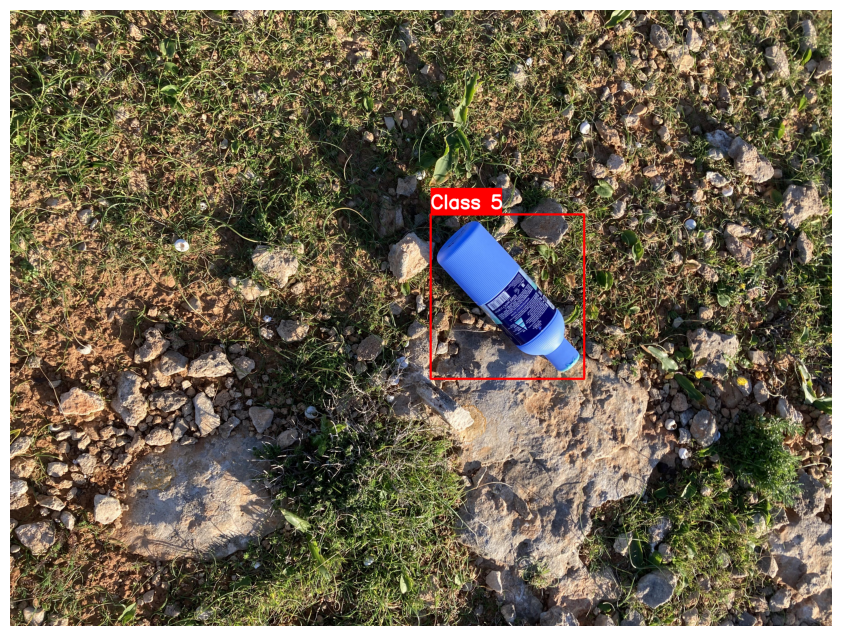

In [12]:
# Assuming `targets` is the list of dictionaries and `sample_image_rgb` is your image
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Convert the image to uint8 (if not already in that format)
sample_image_rgb = sample_image_rgb.astype(np.uint8)

# Iterate over all the targets (boxes and labels)
target = targets[0]  # Example with the first target

boxes = target['boxes'].cpu().numpy()  # Move boxes from GPU to CPU and convert to NumPy
labels = target['labels'].cpu().numpy()  # Get the labels for each box

# Iterate through all the boxes and labels
for i, box in enumerate(boxes):
    # The box is in the format [x_min, y_min, x_max, y_max]
    x_min, y_min, x_max, y_max = box

    # Scale the box coordinates to the image size
    x_min *= sample_image_rgb.shape[1]
    y_min *= sample_image_rgb.shape[0]
    x_max *= sample_image_rgb.shape[1]
    y_max *= sample_image_rgb.shape[0]

    # Convert the coordinates to integers
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    # Draw the rectangle (bounding box) on the image
    cv2.rectangle(sample_image_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 10)

    # Draw the class label text
    class_id = labels[i]  # Class ID for the current box
    class_name = f'Class {class_id}'  # Class label name

    # Get the size of the text to adjust the background rectangle for text
    text_height = 100
    text_width = len(class_name) * 50

    # Draw the background rectangle for the class label text
    cv2.rectangle(sample_image_rgb, (x_min, y_min - int(1.3 * text_height)),
                  (x_min + text_width, y_min), (255, 0, 0), -1)

    # Put the class name text (make it bold and white)
    cv2.putText(sample_image_rgb, class_name, (x_min, y_min - int(0.3 * text_height)),
                cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), thickness=10, lineType=cv2.LINE_AA)

# Remove axis for clarity in plotting
ax.set_axis_off()
ax.imshow(sample_image_rgb)
plt.show()


# Train

In [13]:
# Extract trainable parameters
params = [p for p in model.parameters() if p.requires_grad]
print("Length of trainable parameters: ", len(params))

# Optimizer: AdamW is often better for convergence in object detection models
# AdamW decouples weight decay from the learning rate, improving performance
optimizer = torch.optim.AdamW(params, lr=0.001, weight_decay=0.01)

# Learning rate scheduler: ReduceLROnPlateau adapts learning rate based on validation loss
# More adaptive than StepLR
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5, verbose=True
)

# Early stopping criteria: Patience can be higher for complex models to avoid premature stopping
early_stopping_patience = 8  # Number of epochs without improvement
best_loss = float('inf')
early_stopping_counter = 0

# Number of epochs
num_epochs = 100
loss_hist = Averager()
batch = 1

Length of trainable parameters:  5


c:\Users\User\anaconda3\envs\yolov10\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
# For mAP calculation
# def calculate_map(model, valid_data_loader, iou_threshold=0.2):
#     model.eval()
#     all_preds = []
#     all_labels = []
#     all_scores = []
    
#     with torch.no_grad():
#         for images, targets in valid_data_loader:
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
#             output = model(images)
            
#             # Iterate over the batch and extract predictions and true labels
#             for i in range(len(output)):
#                 pred_boxes = output[i]["boxes"].cpu().numpy()
#                 pred_labels = output[i]["labels"].cpu().numpy()
#                 pred_scores = output[i]["scores"].cpu().numpy()

#                 true_boxes = targets[i]["boxes"].cpu().numpy()
#                 true_labels = targets[i]["labels"].cpu().numpy()

#                 # Filter out predictions with low scores (threshold of 0.5)
#                 keep = pred_scores >= iou_threshold
#                 pred_boxes = pred_boxes[keep]
#                 pred_labels = pred_labels[keep]
#                 pred_scores = pred_scores[keep]

#                 # For each predicted box, compare it to true boxes and labels
#                 for j in range(len(pred_boxes)):
#                     # Add predicted labels and true labels to lists (based on the current image)
#                     all_preds.append(pred_labels[j])  # Predicted class label
#                     all_labels.append(true_labels[j])  # True class label (from the same image)
#                     all_scores.append(pred_scores[j])  # Prediction score
    
#     # Now we calculate mAP using average precision score
#     all_preds = np.array(all_preds)
#     all_labels = np.array(all_labels)
#     all_scores = np.array(all_scores)

#     if len(all_labels) == 0:
#         return 0.0  # No objects detected in the validation set
#     # Use average precision score for multi-class calculation
#     return average_precision_score(all_labels, all_scores, average='macro')


In [15]:
epoch_losses = []
loss_dict_values = []

for epoch in range(num_epochs):
    model.train()
    loss_hist.reset()
    loss_values = []  # Collect batch losses for epoch averaging
    
    start_time = time.time()  # Measure epoch time
    avg_loss_dict = {}  # Average the loss dictionary values

    # Set up tqdm for iteration progress
    total_iterations = len(train_data_loader)
    with tqdm(total=total_iterations, unit=" batch", desc=f"Epoch #{epoch+1}/{num_epochs}") as tepoch:
        for batch, (images, targets) in enumerate(train_data_loader, 1):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)

            # Update the Average loss dictionary
            if not avg_loss_dict:
                avg_loss_dict = {k: [v.item()] for k, v in loss_dict.items()}
            else:
                avg_loss_dict = {k: v + [loss_dict[k].item()] for k, v in avg_loss_dict.items()}

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            loss_values.append(loss_value)  # Track batch loss
            
            # Backward pass and optimizer step
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            # Update tqdm description and increment progress
            tepoch.set_postfix(batch=batch, batch_loss=loss_value)
            tepoch.update(1)  # Increment tqdm for each batch

        # Average the loss dictionary values
        avg_loss_dict = {k: np.mean(v) for k, v in avg_loss_dict.items()}

        # Append the average loss dictionary values to the loss dictionary values list
        loss_dict_values.append(avg_loss_dict)

        # Scheduler step (if provided)
        if lr_scheduler:
            lr_scheduler.step(np.mean(loss_values))

        # Average epoch loss and logging
        epoch_loss_value = np.mean(loss_values)
        epoch_losses.append(epoch_loss_value)

        # Early stopping condition check
        if epoch_loss_value < best_loss:
            best_loss = epoch_loss_value
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Measure epoch time
        time_elapsed = time.time() - start_time

        tepoch.set_postfix(
            avg_epoch_loss=epoch_loss_value,
            early_stopping_counter=early_stopping_counter,
            epoch_time=f"{time_elapsed // 60:.0f}m.{time_elapsed % 60:.0f}s"
        )

        # Early stopping trigger
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch #100/100: 100%|██████████| 79/79 [00:43<00:00,  1.81 batch/s, avg_epoch_loss=1.43, early_stopping_counter=0, epoch_time=0m.44s]


In [16]:
# Convert the loss dictionary values to a dictionary with 4 lists
loss_dict_values = {k: [d[k] for d in loss_dict_values] for k in loss_dict_values[0].keys()}

# Tranfer the keys to capital and remove underscores for better visualization
loss_dict_values = {k.replace('_', ' ').title(): v for k, v in loss_dict_values.items()}

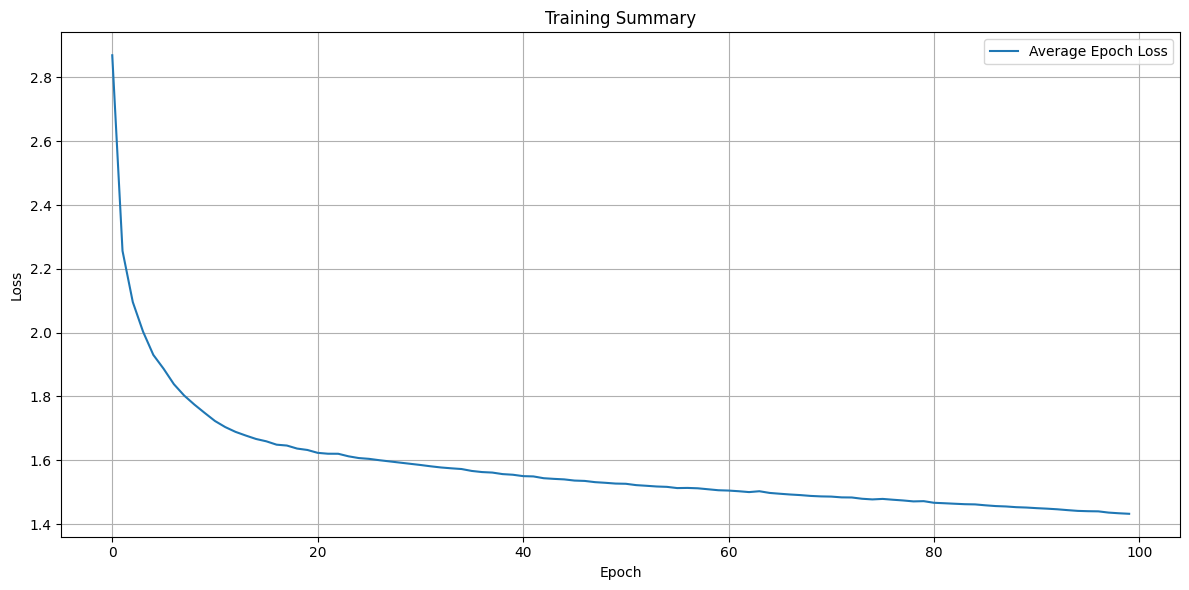

In [17]:
# Display a plot of the loss values
plt.figure(figsize=(12, 6))
plt.plot(epoch_losses, label='Average Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Summary')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

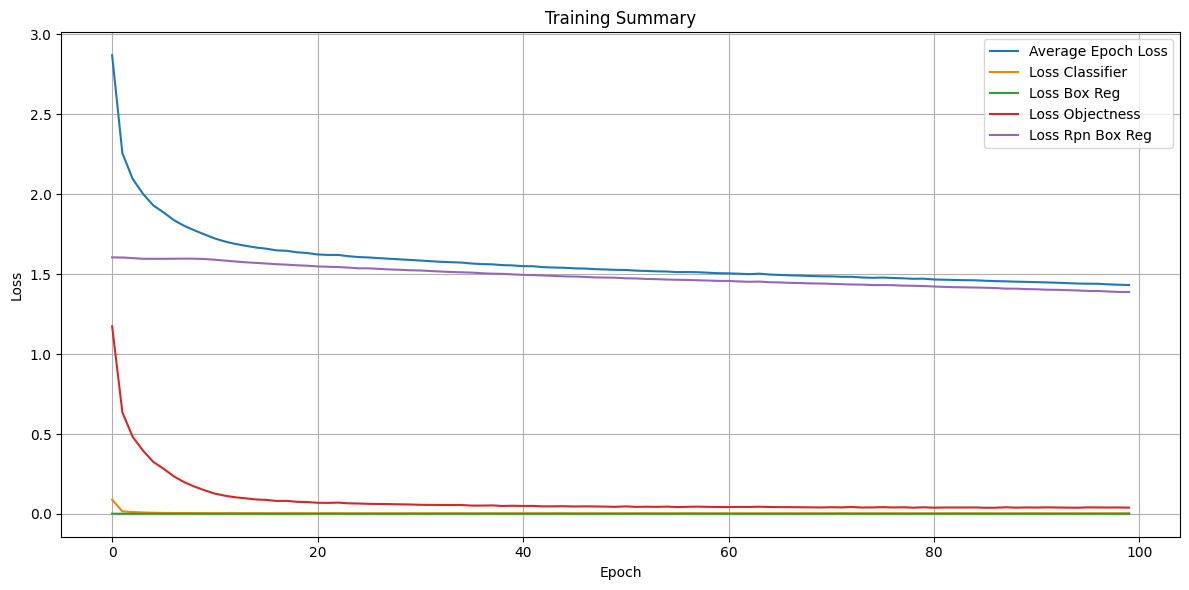

In [18]:
# Display a plot of the loss values
plt.figure(figsize=(12, 6))
plt.plot(epoch_losses, label='Average Epoch Loss')

# Plot the separate losses
for k in loss_dict_values.keys():
    plt.plot(loss_dict_values[k], label=k)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Summary')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
loss_dict

{'loss_classifier': tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0597, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(1.4391, device='cuda:0', grad_fn=<DivBackward0>)}

In [38]:
images, targets = next(iter(valid_data_loader))

In [42]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [43]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [44]:
model.eval()
cpu_device = torch.device("cpu")

with torch.no_grad():
    outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [45]:
outputs

[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])},
 {'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])},
 {'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])},
 {'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

(2048, 1536, 3)


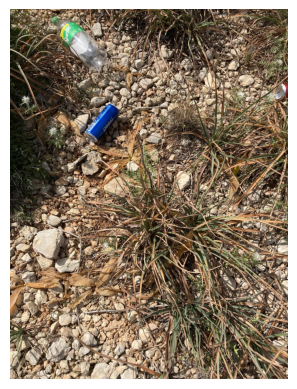

In [39]:
# Extract and reshape the image for the 2nd sample
sample_image = images[0].cpu().numpy()

# Keep only the first 3 RGB channels
red_channel = sample_image[0]
green_channel = sample_image[1]
blue_channel = sample_image[2]
# Edge channel will be ignored for now
# edge_channel = sample_image[3]

red_channel = (red_channel * 255).astype(np.uint8)
green_channel = (green_channel * 255).astype(np.uint8)
blue_channel = (blue_channel * 255).astype(np.uint8)

# Stack the channels to form the RGB image
sample_image_rgb = np.stack([red_channel, green_channel, blue_channel], axis=-1)

print(sample_image_rgb.shape)  # This should give you (height, width, 3) for RGB channels

# Plot the image using Matplotlib
plt.imshow(sample_image_rgb)
plt.axis('off')
plt.show()


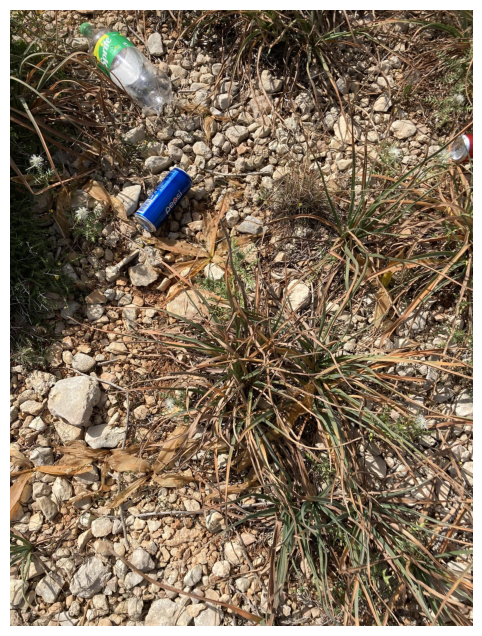

In [40]:
# Assuming `outputs` is the list of dictionaries and `sample_image_rgb` is your image
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Convert the image to uint8 (if not already in that format)
sample_image_rgb = sample_image_rgb.astype(np.uint8)

# Iterate over all the output (boxes and labels)
output = outputs[0]  # Example with the first output

boxes = output['boxes'].detach().numpy()  # Move boxes from GPU to CPU and convert to NumPy
labels = output['labels'].detach().numpy()  # Get the labels for each box

# Iterate through all the boxes and labels
for i, box in enumerate(boxes):
    # The box is in the format [x_min, y_min, x_max, y_max]
    x_min, y_min, x_max, y_max = box

    # Scale the box coordinates to the image size
    x_min *= sample_image_rgb.shape[1]
    y_min *= sample_image_rgb.shape[0]
    x_max *= sample_image_rgb.shape[1]
    y_max *= sample_image_rgb.shape[0]

    # Convert the coordinates to integers
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    # Draw the rectangle (bounding box) on the image
    cv2.rectangle(sample_image_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 10)

    # Draw the class label text
    class_id = labels[i]  # Class ID for the current box
    class_name = f'Class {class_id}'  # Class label name

    # Get the size of the text to adjust the background rectangle for text
    text_height = 100
    text_width = len(class_name) * 50

    # Draw the background rectangle for the class label text
    cv2.rectangle(sample_image_rgb, (x_min, y_min - int(1.3 * text_height)),
                  (x_min + text_width, y_min), (255, 0, 0), -1)

    # Put the class name text (make it bold and white)
    cv2.putText(sample_image_rgb, class_name, (x_min, y_min - int(0.3 * text_height)),
                cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), thickness=10, lineType=cv2.LINE_AA)

# Remove axis for clarity in plotting
ax.set_axis_off()
ax.imshow(sample_image_rgb)
plt.show()


In [27]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn_100epochs.pth')